### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

In [ ]:
#Converto le immagini in tensori e standardizzo utilizzando media e deviazione standard.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#Caricamento dei dati. In MNIST sono già ripartiti in train set (60000) e test set (10000), non è presente invece la ripartizione per il validation set.
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#Creazione dei data loader.
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]


In [ ]:
#Funzione per addestrare il modello.
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train() #abilita dropout, batch normalization, etc.
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1)==labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

#Funzione per valutare il modello.
def evaluate(model, validation_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in validation_loader:
            data, labels = data.to(device), labels.to(device)
            pred = model(data)
            loss = criterion(pred, labels)

            total_loss += loss.item()
            correct += (pred.argmax(1)==labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(validation_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc, test_acc=None, is_final=False):
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_acc, epoch)
    writer.add_scalar('Accuracy/Validation', val_acc, epoch)

    if test_acc is not None:
        if is_final:
            writer.add_scalar('Accuracy/Test', test_acc, epoch)
        else:
            writer.add_scalar('Accuracy/Test', test_acc, epoch)

def plot_training_results(history, test_acc, figsize=(12, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(history['train_acc'], label='Train Acc', color='blue')
    ax2.plot(history['val_acc'], label='Val Acc', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    print(f"Miglior training accuracy: {max(history['train_acc']):.2f}%")
    print(f"Miglior validation accuracy: {max(history['val_acc']):.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

In [ ]:
#Creazione del modello MLP.
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        layer_sizes = [input_size] + hidden_size + [output_size] #in questo caso si ha [784, 16, 16, 10]
        layers = []

        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1])) #crea layer lineari tra ogni coppia di dimensioni consecutive
            if i < len(layer_sizes)-2:
                layers.append(nn.ReLU()) #aggiunge una funzione di attivazione ReLU dopo ogni layer tranne il layer finale
        self.layers = nn.Sequential (*layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) #appiattisce l'input
        x = self.layers(x) #propagazione sequenziale
        return x


Epoch  1/20: Train Loss: 2.3092, Train Acc: 11.30% | Validation Loss: 2.3067, Val Acc: 10.91%
Epoch  2/20: Train Loss: 2.3061, Train Acc: 11.30% | Validation Loss: 2.3045, Val Acc: 10.91%
Epoch  3/20: Train Loss: 2.3045, Train Acc: 11.30% | Validation Loss: 2.3034, Val Acc: 10.91%
Epoch  4/20: Train Loss: 2.3035, Train Acc: 11.30% | Validation Loss: 2.3026, Val Acc: 10.91%
Epoch  5/20: Train Loss: 2.3027, Train Acc: 11.30% | Validation Loss: 2.3020, Val Acc: 10.91%
Epoch  6/20: Train Loss: 2.2970, Train Acc: 11.31% | Validation Loss: 2.1429, Val Acc: 14.66%
Epoch  7/20: Train Loss: 1.9687, Train Acc: 20.96% | Validation Loss: 1.9151, Val Acc: 29.30%
Epoch  8/20: Train Loss: 1.8524, Train Acc: 30.45% | Validation Loss: 1.7921, Val Acc: 34.54%
Epoch  9/20: Train Loss: 1.7165, Train Acc: 38.07% | Validation Loss: 1.6440, Val Acc: 40.89%
Epoch 10/20: Train Loss: 1.5667, Train Acc: 43.00% | Validation Loss: 1.4905, Val Acc: 44.93%
Epoch 11/20: Train Loss: 1.4172, Train Acc: 44.81% | Validat

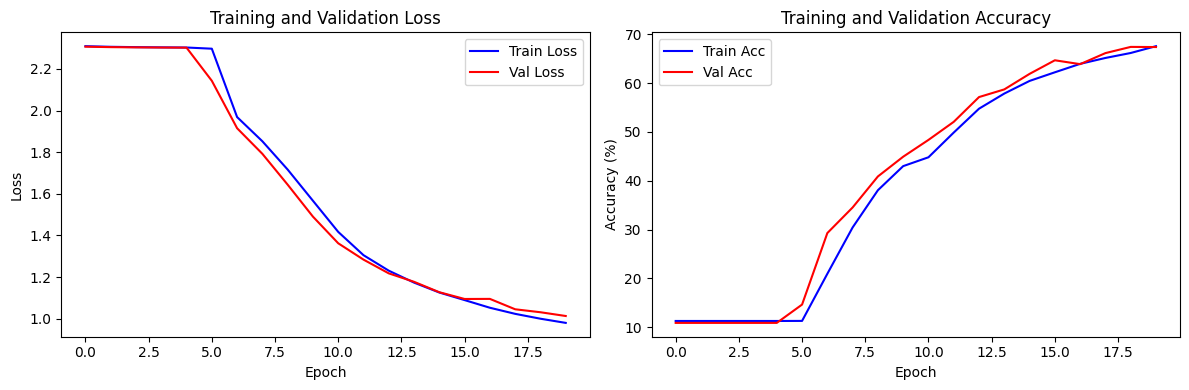

Miglior training accuracy: 67.56%
Miglior validation accuracy: 67.41%
Test Accuracy: 66.85%


In [ ]:
#Parametri del modello.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 28*28
width = 16
depth = 20

MLP_model = MLP(input_size, [width]*depth, 10).to(device)

#Parametri di training.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_model.parameters(), lr=0.0001)
epochs = 20

#Apertura del writer di tensorboard.
writer = SummaryWriter('runs/mlp_mnist')

#Salvataggio dei risultati di training.
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

#Training
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(MLP_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(MLP_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

#Valutazione sul test set.
test_loss, test_acc = evaluate(MLP_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

log_to_tensorboard(writer, epochs, train_loss, train_acc, val_loss, val_acc, test_acc, is_final=True)

#Chiusura del writer di tensorboard.
writer.close()

plot_training_results(history, test_acc)

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case.

In [ ]:
#Creazione del blocco residuale MLP.
class ResidualMLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ResidualMLPBlock, self).__init__()
        layer_sizes = [input_size] + hidden_size + [output_size]
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
        if input_size != output_size:
            self.residual_connection = nn.Linear(input_size, output_size) #effettua una proiezione se l'input e l'output non hanno la stessa dimensione
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        x = self.layers(x)
        return x + residual


#Creazione del modello MLP con blocchi residuali.
class MLPResidual(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks):
        super(MLPResidual, self).__init__()
        self.flatten = nn.Flatten()
        layers = []
        for i in range (num_blocks):
            layers.append(ResidualMLPBlock(input_size if i ==0 else output_size, hidden_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

Epoch  1/20: Train Loss: 1.1906, Train Acc: 68.73% | Validation Loss: 0.6892, Val Acc: 84.47%
Epoch  2/20: Train Loss: 0.5728, Train Acc: 86.07% | Validation Loss: 0.4926, Val Acc: 87.79%
Epoch  3/20: Train Loss: 0.4527, Train Acc: 88.23% | Validation Loss: 0.4209, Val Acc: 88.86%
Epoch  4/20: Train Loss: 0.3985, Train Acc: 89.27% | Validation Loss: 0.3836, Val Acc: 89.45%
Epoch  5/20: Train Loss: 0.3671, Train Acc: 89.88% | Validation Loss: 0.3609, Val Acc: 90.08%
Epoch  6/20: Train Loss: 0.3466, Train Acc: 90.40% | Validation Loss: 0.3459, Val Acc: 90.39%
Epoch  7/20: Train Loss: 0.3318, Train Acc: 90.73% | Validation Loss: 0.3346, Val Acc: 90.72%
Epoch  8/20: Train Loss: 0.3210, Train Acc: 91.01% | Validation Loss: 0.3260, Val Acc: 90.93%
Epoch  9/20: Train Loss: 0.3120, Train Acc: 91.25% | Validation Loss: 0.3201, Val Acc: 91.09%
Epoch 10/20: Train Loss: 0.3052, Train Acc: 91.47% | Validation Loss: 0.3150, Val Acc: 91.27%
Epoch 11/20: Train Loss: 0.2995, Train Acc: 91.57% | Validat

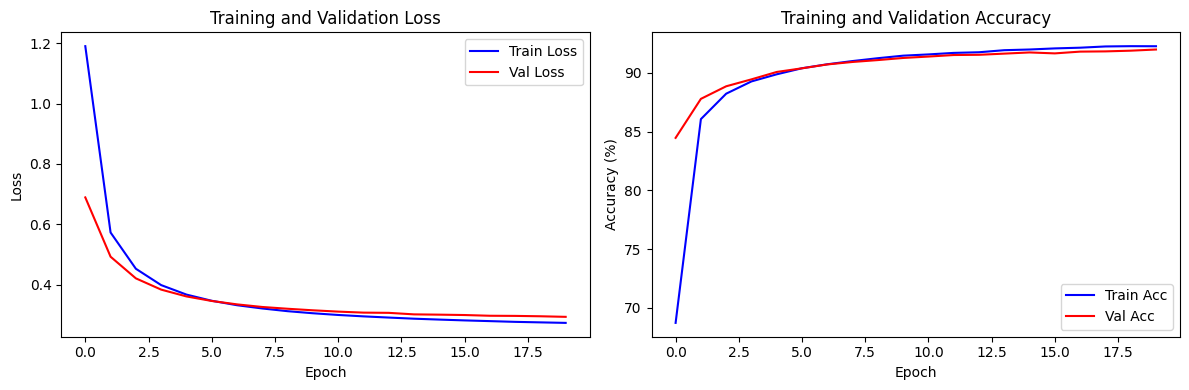

Miglior training accuracy: 92.27%
Miglior validation accuracy: 91.99%
Test Accuracy: 92.19%


In [ ]:
#Parametri del modello.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 28*28
width = 16
depth = 20

MLP_residual_model = MLPResidual(input_size, [width]*depth, 10, 4).to(device)

#Parametri di training.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_residual_model.parameters(), lr=0.0001)
epochs = 20

#Configurazione del writer di tensorboard.
writer = SummaryWriter('runs/residual_mlp_mnist')

#Salvataggio dei risultati di training.
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

#Training.
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(MLP_residual_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(MLP_residual_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

#Valutazione sul test set.
test_loss, test_acc = evaluate(MLP_residual_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

log_to_tensorboard(writer, epochs, train_loss, train_acc, val_loss, val_acc, test_acc, is_final=True)

#Chiusura del writer di tensorboard.
writer.close()

plot_training_results(history, test_acc)

* Per depth = 2 si osservano i seguenti risultati per **MLP senza residual connections**:  

  Miglior training accuracy: 93.16%  

  Miglior validation accuracy: 92.64%  

  Test Accuracy: 93.12%  

  Per **MLP con residual connections** si osserva invece:  

  Miglior training accuracy: 95.74%  

  Miglior validation accuracy: 94.88%  

  Test Accuracy: 94.99%  

* Per depth = 10 si osservano i seguenti risultati per **MLP senza residual connections**:  

  Miglior training accuracy: 71.23%  

  Miglior validation accuracy: 70.91%  

  Test Accuracy: 70.98%  

  Per **MLP con residual connections** si osserva invece:  

  Miglior training accuracy: 95.80%  

  Miglior validation accuracy: 94.60%  

  Test Accuracy: 94.82%  

* Per depth = 20 si osservano i seguenti risultati per MLP senza residual connections:  

  Miglior training accuracy: 67.56%  

  Miglior validation accuracy: 67.41%  

  Test Accuracy: 66.85%  

  Per **MLP con residual connections**si osserva invece:  

  Miglior training accuracy: 92.27%  

  Miglior validation accuracy: 91.99%  

  Test Accuracy: 92.19%

Questi risultati confermano quanto previsto: MLP con blocchi residuali mantiene delle ottime performance per qualsiasi grado di profondità, mentre le prestazioni del modello MLP senza blocchi residuali calano all'aumentare della profondità della rete.

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving.

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
#Converto le immagini in tensori e standardizzo utilizzando media e deviazione standard.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Media/std di CIFAR-10
])

#Caricamento dei dati. In CIFAR10 sono già ripartiti in train set (40000) e test set (10000), non è presente invece la ripartizione
#per il validation set.
full_train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_size = 40000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#Creazione dei data loader.
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


In [ ]:
#Creazione del blocco senza connessioni residuali.
class NoResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channel)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        return x

In [ ]:
#Creazione del blocco con connessioni residuali.
class ResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channel)

        if input_channel != output_channel or stride != 1:
            self.residual_connection = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channel)
            )
        else:
            self.residual_connection = nn.Identity()

    def forward(self, x):
        residual = self.residual_connection(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = F.relu(x)
        return x

In [ ]:
#Creazione della rete ResNet18. Alcuni parametri vengono modificati per adattare meglio la rete al dataset, per questo stesso motivo non si applica max pooling.
class ResNet(nn.Module):
    def __init__(self, block_type, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layers = nn.ModuleList()
        in_out_channels = [(16, 16), (16, 32), (32, 64), (64, 128)]
        strides = [1, 2, 2, 2]
        num_blocks = [2, 2, 2, 2]
        for (in_ch, out_ch), stride, blocks in zip(in_out_channels, strides, num_blocks):
            layer_group = nn.ModuleList()
            for i in range(blocks):
                if i == 0:
                    block = block_type(in_ch, out_ch, stride=stride)
                else:
                    block = block_type(out_ch, out_ch, stride=1)
                layer_group.append(block)
                in_ch = out_ch
            self.layers.append(nn.Sequential(*layer_group))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        for layer_group in self.layers:
            x = layer_group(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Epoch  1/20: Train Loss: 1.9535, Train Acc: 23.48% | Validation Loss: 1.9985, Val Acc: 23.54%
Epoch  2/20: Train Loss: 1.7565, Train Acc: 31.10% | Validation Loss: 1.8516, Val Acc: 29.86%
Epoch  3/20: Train Loss: 1.6478, Train Acc: 36.47% | Validation Loss: 2.3416, Val Acc: 25.00%
Epoch  4/20: Train Loss: 1.5608, Train Acc: 40.77% | Validation Loss: 1.6723, Val Acc: 37.40%
Epoch  5/20: Train Loss: 1.4852, Train Acc: 44.47% | Validation Loss: 1.4487, Val Acc: 45.88%
Epoch  6/20: Train Loss: 1.4025, Train Acc: 48.10% | Validation Loss: 1.6265, Val Acc: 42.02%
Epoch  7/20: Train Loss: 1.3524, Train Acc: 50.05% | Validation Loss: 1.4306, Val Acc: 47.76%
Epoch  8/20: Train Loss: 1.3027, Train Acc: 52.42% | Validation Loss: 1.4472, Val Acc: 47.48%
Epoch  9/20: Train Loss: 1.2649, Train Acc: 53.99% | Validation Loss: 1.2771, Val Acc: 53.41%
Epoch 10/20: Train Loss: 1.2346, Train Acc: 54.99% | Validation Loss: 1.3666, Val Acc: 50.78%
Epoch 11/20: Train Loss: 1.1929, Train Acc: 56.88% | Validat

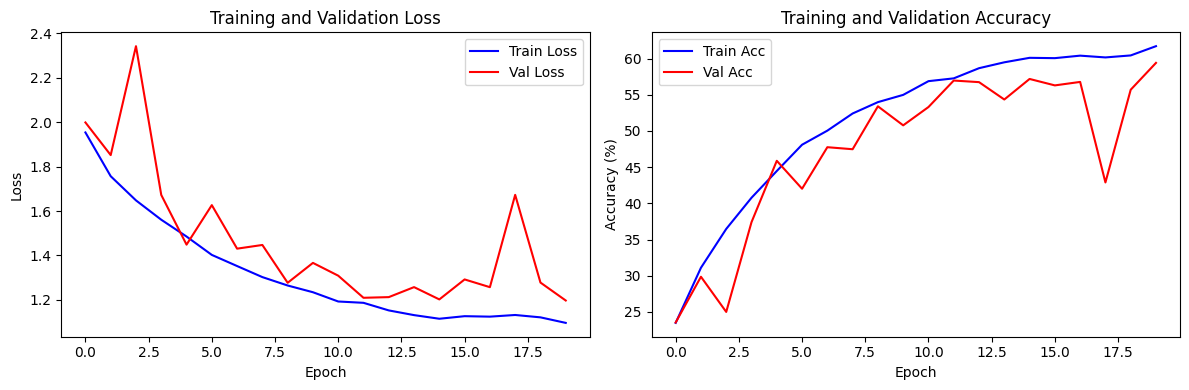

Miglior training accuracy: 61.72%
Miglior validation accuracy: 59.41%
Test Accuracy: 59.68%


In [ ]:
#Parametri del modello.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_no_residual_model = ResNet(block_type=NoResidualBlock).to(device)

#Parametri di training.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_no_residual_model.parameters(), lr=0.001)
epochs = 20

#Apertura del writer di tensorboard.
writer = SummaryWriter('runs/noresidual_resnet_cifar')

#Salvataggio dei risultati di training.
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

#Training.
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(resnet_no_residual_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(resnet_no_residual_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

#Valutazione sul test set.
test_loss, test_acc = evaluate(resnet_no_residual_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

log_to_tensorboard(writer, epochs, train_loss, train_acc, val_loss, val_acc, test_acc, is_final=True)

#Chiusura del writer di tensorboard.
writer.close()

plot_training_results(history, test_acc)

Epoch  1/20: Train Loss: 1.6229, Train Acc: 39.73% | Validation Loss: 1.4692, Val Acc: 46.75%
Epoch  2/20: Train Loss: 1.3088, Train Acc: 52.37% | Validation Loss: 1.4705, Val Acc: 49.89%
Epoch  3/20: Train Loss: 1.1559, Train Acc: 58.37% | Validation Loss: 1.4519, Val Acc: 50.59%
Epoch  4/20: Train Loss: 1.0444, Train Acc: 62.55% | Validation Loss: 1.0664, Val Acc: 62.24%
Epoch  5/20: Train Loss: 0.9572, Train Acc: 65.72% | Validation Loss: 1.0096, Val Acc: 64.44%
Epoch  6/20: Train Loss: 0.8857, Train Acc: 68.81% | Validation Loss: 0.9466, Val Acc: 66.58%
Epoch  7/20: Train Loss: 0.8341, Train Acc: 70.60% | Validation Loss: 0.9541, Val Acc: 66.79%
Epoch  8/20: Train Loss: 0.7884, Train Acc: 72.08% | Validation Loss: 0.9071, Val Acc: 68.45%
Epoch  9/20: Train Loss: 0.7450, Train Acc: 73.71% | Validation Loss: 0.8347, Val Acc: 71.03%
Epoch 10/20: Train Loss: 0.7119, Train Acc: 74.92% | Validation Loss: 0.8582, Val Acc: 70.23%
Epoch 11/20: Train Loss: 0.6863, Train Acc: 75.90% | Validat

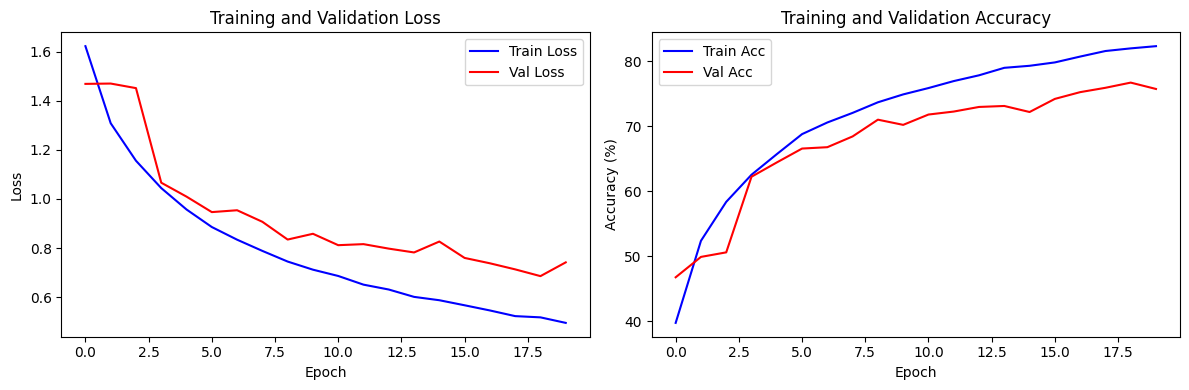

Miglior training accuracy: 82.35%
Miglior validation accuracy: 76.74%
Test Accuracy: 75.28%


In [ ]:
#Parametri del modello.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet_residual_model = ResNet(block_type=ResidualBlock).to(device)

#Parametri di training.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_residual_model.parameters(), lr=0.001)
epochs = 20

#Apertura del writer di tensorboard.
writer = SummaryWriter('runs/residual_resnet_cifar')

#Salvataggio dei risultati di training.
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

#Training.
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(resnet_residual_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(resnet_residual_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

#Valutazione sul test set.
test_loss, test_acc = evaluate(resnet_residual_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

log_to_tensorboard(writer, epochs, train_loss, train_acc, val_loss, val_acc, test_acc, is_final=True)

#Chiusura del writer di tensorboard.
writer.close()

plot_training_results(history, test_acc)

  * Per depth = 18 si osservano i seguenti risultati per **CNN senza residual connections**:  

    Miglior training accuracy: 78.58%  

    Miglior validation accuracy: 74.47%

    Test Accuracy: 73.66%

    Per **CNN con residual connections** si osserva invece:  

    Miglior training accuracy: 82.38%

    Miglior validation accuracy: 77.04%

    Test Accuracy: 77.23%

  * Per depth = 26 si osservano i seguenti risultati per **CNN senza residual connections**:  

    Miglior training accuracy: 75.47%

    Miglior validation accuracy: 71.89%

    Test Accuracy: 71.72%  

    Per **CNN con residual connections** si osserva invece:

    Miglior training accuracy: 82.95%

    Miglior validation accuracy: 76.72%
    
    Test Accuracy: 76.17%  

  * Per depth = 34 si osservano i seguenti risultati per **CNN senza residual connections**:  

    Miglior training accuracy: 61.72%

    Miglior validation accuracy: 59.41%  

    Test Accuracy: 59.68%

    Per **CNN con residual connections** si osserva invece:

    Miglior training accuracy: 82.39%

    Miglior validation accuracy: 76.67%

    Test Accuracy: 76.31%

Anche in questo caso si osserva che le prestazioni dei modelli senza connessioni residuali peggiorano all'aumentare della profondità della rete, mentre i modelli con connessioni residuali riescono a mantenere delle buone performance.


### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
#Caricamento del dataset CIFAR100 e standardizzazione dei dati.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

full_train_dataset_100 = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
test_dataset_100 = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

train_size = 40000
val_size = 10000
train_dataset_100, val_dataset_100 = random_split(full_train_dataset_100, [train_size, val_size])

#Creazione dei data loader.
batch_size = 128
train_loader_100 = DataLoader(train_dataset_100, batch_size=batch_size, shuffle=True)
val_loader_100 = DataLoader(val_dataset_100, batch_size=batch_size, shuffle=False)
test_loader_100 = DataLoader(test_dataset_100, batch_size=batch_size, shuffle=False)

In [ ]:
#Creazione della baseline dal modello già precedentemente addestrato, rimuovendo l'ultimo layer di classificazione allo scopo estrarre le features.
baseline_model = copy.deepcopy(resnet_residual_model)

baseline_model.fc = nn.Identity()
baseline_model.eval()

def extract_features(model, dataloader, device):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in (dataloader):
            images = images.to(device)
            feats = model(images)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

train_features, train_labels = extract_features(baseline_model, train_loader_100, device) #estrazione delle features
test_features, test_labels = extract_features(baseline_model, test_loader_100, device) #estrazione delle features
svm = LinearSVC(max_iter=5000)
svm.fit(train_features, train_labels) #addestramento del Linear SVM
pred_labels = svm.predict(test_features) #ottengo le predizioni
acc = accuracy_score(test_labels, pred_labels) #calcolo l'accuracy
print(f"Accuracy Linear SVM on CIFAR-100 features: {acc*100:.2f}%")

Accuracy Linear SVM on CIFAR-100 features: 25.54%


Epoch  1/20: Train Loss: 1.0105, Train Acc: 76.77% | Validation Loss: 0.6681, Val Acc: 78.13%
Epoch  2/20: Train Loss: 0.4757, Train Acc: 85.12% | Validation Loss: 0.6282, Val Acc: 78.45%
Epoch  3/20: Train Loss: 0.4363, Train Acc: 85.69% | Validation Loss: 0.6137, Val Acc: 78.94%
Epoch  4/20: Train Loss: 0.4116, Train Acc: 86.22% | Validation Loss: 0.6061, Val Acc: 79.25%
Epoch  5/20: Train Loss: 0.4104, Train Acc: 86.08% | Validation Loss: 0.6155, Val Acc: 79.11%
Epoch  6/20: Train Loss: 0.3979, Train Acc: 86.41% | Validation Loss: 0.6075, Val Acc: 79.69%
Epoch  7/20: Train Loss: 0.3920, Train Acc: 86.34% | Validation Loss: 0.6044, Val Acc: 79.88%
Epoch  8/20: Train Loss: 0.3864, Train Acc: 86.58% | Validation Loss: 0.6044, Val Acc: 79.70%
Epoch  9/20: Train Loss: 0.3819, Train Acc: 86.79% | Validation Loss: 0.6152, Val Acc: 79.55%
Epoch 10/20: Train Loss: 0.3804, Train Acc: 86.83% | Validation Loss: 0.6173, Val Acc: 79.62%
Epoch 11/20: Train Loss: 0.3730, Train Acc: 87.06% | Validat

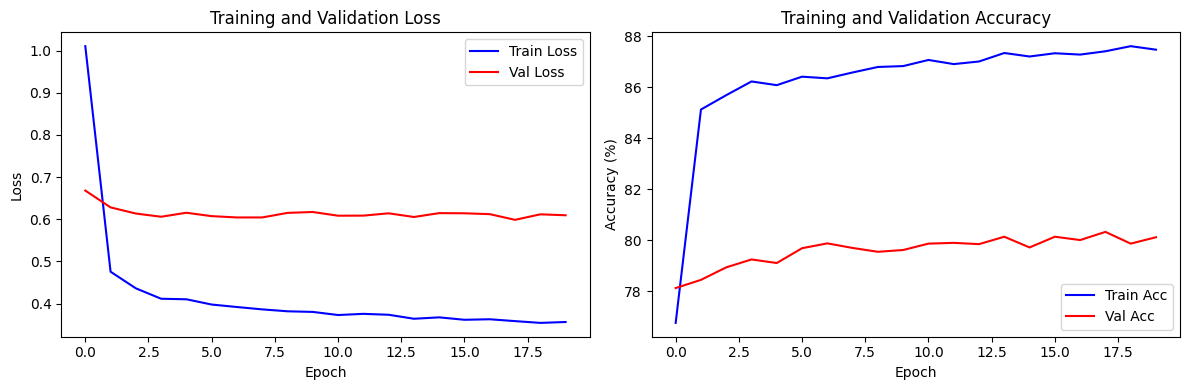

Miglior training accuracy: 87.61%
Miglior validation accuracy: 80.33%
Test Accuracy: 80.15%


In [ ]:
#Creazione del modello sostituendo l'ultimo layer con un nuovo classificatore che presenta il numero di classi del dataset CIFAR-100.
finetuned_model = copy.deepcopy(resnet_residual_model)
finetuned_model.fc = nn.Linear(128, 100)
finetuned_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(finetuned_model.parameters(), lr=0.001, momentum = 0.9)
epochs = 20

#Apertura del writer di tensorboard.
writer = SummaryWriter('runs/finetuned_resnet_cifar')

#Salvataggio dei risultati di training.
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

#Training.
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(finetuned_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(finetuned_model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    log_to_tensorboard(writer, epoch, train_loss, train_acc, val_loss, val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

#Valutazione sul test set.
test_loss, test_acc = evaluate(finetuned_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

log_to_tensorboard(writer, epochs, train_loss, train_acc, val_loss, val_acc, test_acc, is_final=True)

#Chiusura del writer di tensorboard.
writer.close()

plot_training_results(history, test_acc)

L'accuracy per Linear SVM è 25.54%.  
L'accuracy per il finetuning eseguito senza congelare alcun layer e con optimizer Adam è 78.75%.  
L'accuracy per il finetuning eseguito senza congelare alcun layer e con optimizer SGD è 80.15%.   
L'accuracy per il finetuning eseguito addestrando solo il classificatore finale con optimizer Adam è 78.63%.  
L'accuracy per il finetuning eseguito addestrando solo il classificatore finale con optimizer SGD è 78.21%.  

Dai risultati ottenuti si evince che il modello dopo aver effettuato il finetuning ottiene dei risultati nettamente superiori alla baseline.